# Load in relevant classes for tests.

In [1]:
from trust_simulator import TrustSimulator
from institution import Institution
import matplotlib.pyplot as plt
from society import Society
import numpy as np

%matplotlib inline
plt.style.use('fivethirtyeight')

# Adding function to make plots from paper.

In [4]:
def plot_society_trust_histories(society):
    for person in society.person_vector:
        signal = np.array(person._trust_history)
        pos_signal = signal.copy()
        neg_signal = signal.copy()

        pos_signal[pos_signal <= 0] = np.nan
        neg_signal[neg_signal > 0] = np.nan

        #plotting
        plt.style.use('fivethirtyeight')
        plt.plot(pos_signal, color='r')
        plt.plot(neg_signal, color='b')

# We want to replicate results directly from Baumann et. al 2020, so we will use the same test parameters. Note: this first part is checking JUST the society updates, and no law updates. This can be easily done by setting the update_weight_laws = 0.

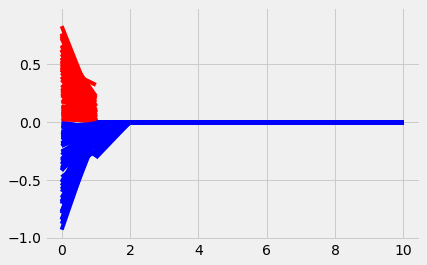

In [7]:
# Define constants
alpha = 0.05
beta = 0
population_size = 250
connectivity_probability = 0.1
iterations = 10
update_weight_laws = 0
# Run simulations
society = Society(population_size=population_size,
                  connectivity_probability=connectivity_probability)
institution = Institution(society=society)
trust_simulator = TrustSimulator()
societal_trust = trust_simulator.simulate_society(society=society,
                                                  institution=institution,
                                                  iterations=iterations,
                                                  alpha=alpha,
                                                  affiliation_prob=beta,
                                                  update_weight_laws=update_weight_laws)
plot_society_trust_histories(society)

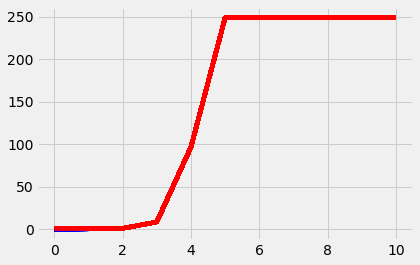

In [8]:
# Define constants
alpha = 0.05
beta = 2
population_size = 250
connectivity_probability = 0.1
iterations = 10
update_weight_laws = 0
# Run simulations
society = Society(population_size=population_size,
                  connectivity_probability=connectivity_probability)
institution = Institution(society=society)
trust_simulator = TrustSimulator()
societal_trust = trust_simulator.simulate_society(society=society,
                                                  institution=institution,
                                                  iterations=iterations,
                                                  alpha=alpha,
                                                  affiliation_prob=beta,
                                                  update_weight_laws=update_weight_laws)
plot_society_trust_histories(society)

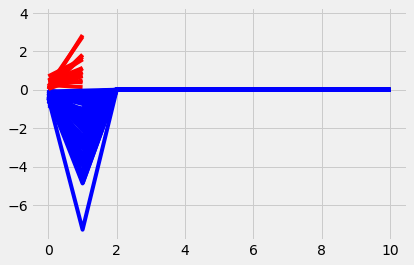

In [7]:
# Define constants
alpha = 3
beta = 0
population_size = 100
connectivity_probability = 0.1
iterations = 10
update_weight_laws = 0
# Run simulations
society = Society(population_size=population_size,
                  connectivity_probability=connectivity_probability)
institution = Institution(society=society)
trust_simulator = TrustSimulator()
societal_trust = trust_simulator.simulate_society(society=society,
                                                  institution=institution,
                                                  iterations=iterations,
                                                  alpha=alpha,
                                                  affiliation_prob=beta,
                                                  update_weight_laws=update_weight_laws)
plot_society_trust_histories(society)

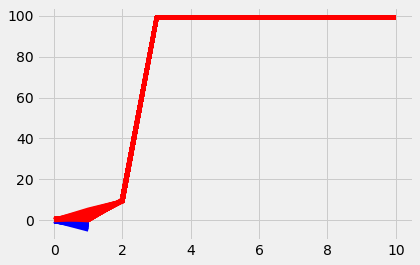

In [8]:
# Define constants
alpha = 3
beta = 3
population_size = 100
connectivity_probability = 0.1
iterations = 10
update_weight_laws = 0
# Run simulations
society = Society(population_size=population_size,
                  connectivity_probability=connectivity_probability)
institution = Institution(society=society)
trust_simulator = TrustSimulator()
societal_trust = trust_simulator.simulate_society(society=society,
                                                  institution=institution,
                                                  iterations=iterations,
                                                  alpha=alpha,
                                                  affiliation_prob=beta,
                                                  update_weight_laws=update_weight_laws)
plot_society_trust_histories(society)